In [2]:
import pandas as pd
import numpy as np 
from utils import load_data, convert 

In [3]:
bad_subj = ['168139','361941', '257845', '671855'] 
data = load_data(bad_subj_include=bad_subj)

Number of subjects: 789
Data contains: 
thick shape (302310,) 
logjac shape (302310,) 
labels shape (302310,)           
mean_area shape (302310,) 


In [24]:
idx

array([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70])

In [ ]:
import numpy as np
import pandas as pd
import pickle

import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from data_load import load_data
from utils import get_nodes_attribute, get_all_attr, rich_cl, to_degree, local_measure

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, ShuffleSplit


path = '/cobrain/groups/ml_group/data/HCP/HCP/'
connec , thinkness, log_jac, unique_labels, labels, mean_area_eq, idx_subj_connec, idx_subj_think, idx_subj_logjac = load_data(path)


thinkness = thinkness.reshape(789, -1)
log_jac = log_jac.reshape(789, -1)
mean_area_eq = mean_area_eq.reshape(-1)
labels = labels.reshape(-1)

idx = np.array(list(range(4)) + list(range(5,39)) + list(range(40, 70)))
roi_think = []
for i in range(68):
    loc_idx = np.where(labels == idx[i])[0]
    roi_think += [np.mean(thinkness[:,loc_idx], axis = -1)]
roi_think = np.array(roi_think).T

roi_area = []
for i in range(68):
    loc_idx = np.where(labels == idx[i])[0]
    roi_area += [np.sum(mean_area_eq[loc_idx]*np.exp(log_jac[:, loc_idx]), axis = -1)]
roi_area = np.array(roi_area).T


roi_vol = []
for i in range(68):
    loc_idx = np.where(labels == idx[i])[0]
    roi_vol += [np.sum(mean_area_eq[loc_idx]*np.exp(log_jac[:, loc_idx]) * thinkness[:,loc_idx], axis = -1)]
    
roi_vol = np.array(roi_vol).T

path_data = "/cobrain/groups/ml_group/data/HCP/cleaned_data/"
    
targets_name = ['clustering', 'rich_club', 'betweenness', 'closeness',  'degree_centrality', 'eigenvector']

targets_data = []
for name in targets_name:
    with open(path_data + name, 'rb') as f:
        targets_data  += [pickle.load(f)]

print(np.array(targets_data).shape)


cv = ShuffleSplit(n_splits=3, test_size=0.2)



elastic_param = {'alpha': [ 1e-5, 1e-3, 0.1, 1.0, 5, 10, ], 
                 'l1_ratio': [1e-5, 1e-3, 0.1, 0.4, 1, 5.],
                 'max_iter':[10000]}




path_res = '/home/ayagoz/connec/results/'


if not os.path.exists(path_res + 'roi_node'):
    os.mkdir(path_res + 'roi_node')
path_res += 'roi_node/'
Y = connec[:,0,:,:]
wdeg = Y.sum(axis = -1)                 
X = np.concatenate([roi_think, roi_area, roi_vol], axis= -1)
print('Fit ElasticNet for weighted degree')
elastic = ElasticNet()
StanS = StandardScaler()
MinM = MinMaxScaler()
cv = ShuffleSplit(test_size=0.2)
rg =GridSearchCV(elastic, elastic_param, scoring = 'r2', 
                        n_jobs=-1, cv = cv)

rg.fit(X, wdeg)
orig = pd.DataFrame.from_dict(rg.cv_results_)
orig = orig.sort_values(by = 'rank_test_score').iloc[:1]

rg.fit(StanS.fit_transform(X), wdeg)
st = pd.DataFrame.from_dict(rg.cv_results_)
st = st.sort_values(by = 'rank_test_score').iloc[:1]

rg.fit(MinM.fit_transform(X), wdeg)
mm = pd.DataFrame.from_dict(rg.cv_results_)
mm = mm.sort_values(by = 'rank_test_score').iloc[:1]

name_dir = 'exper_elastic_roi_node_weighted_degree'
if not os.path.exists(path_res + name_dir):
    os.mkdir(path_res + name_dir)


orig.to_csv(path_res + name_dir +'/results_orig')
st.to_csv(path_res + name_dir + '/results_st')
mm.to_csv(path_res + name_dir + '/results_mm')
#print(path_res)
for j, target in enumerate(targets_data):
    print(targets_name[j])
    print(target.shape)

    print('Fit ElasticNet for ', targets_name[j])
    elastic = ElasticNet()
    StanS = StandardScaler()
    MinM = MinMaxScaler()
    cv = ShuffleSplit(test_size=0.2)
    rg =GridSearchCV(elastic, elastic_param, scoring = 'r2', 
                            n_jobs=-1, cv = cv)
    
    rg.fit(X, target)
    orig = pd.DataFrame.from_dict(rg.cv_results_)
    orig = orig.sort_values(by = 'rank_test_score').iloc[:1]

    rg.fit(StanS.fit_transform(X), target)
    st = pd.DataFrame.from_dict(rg.cv_results_)
    st = st.sort_values(by = 'rank_test_score').iloc[:1]

    rg.fit(MinM.fit_transform(X), target)
    mm = pd.DataFrame.from_dict(rg.cv_results_)
    mm = mm.sort_values(by = 'rank_test_score').iloc[:1]

    name_dir = 'exper_elastic_roi_node_' + targets_name[j]
    if not os.path.exists(path_res + name_dir):
        os.mkdir(path_res + name_dir)


    orig.to_csv(path_res + name_dir +'/results_orig')
    st.to_csv(path_res + name_dir + '/results_st')
    mm.to_csv(path_res + name_dir + '/results_mm')


In [21]:
idx

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

In [ ]:
import numpy as np
import pandas as pd
import pickle

import os

from data_load import load_data
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, ShuffleSplit



path = '/cobrain/groups/ml_group/data/HCP/HCP/'
connec , thinkness, log_jac, unique_labels, labels, mean_area_eq, idx_subj_connec, idx_subj_think, idx_subj_logjac = load_data(path)


thinkness = thinkness.reshape(789, -1)
log_jac = log_jac.reshape(789, -1)
mean_area_eq = mean_area_eq.reshape(-1)
labels = labels.reshape(-1)

idx = np.array(list(range(1,4)) + list(range(5,39)) + list(range(40, 71)))
roi_think = []
for i in range(68):
    loc_idx = np.where(labels == idx[i])[0]
    roi_think += [np.mean(thinkness[:,loc_idx], axis = -1)]
roi_think = np.array(roi_think).T

roi_area = []
for i in range(68):
    loc_idx = np.where(labels == idx[i])[0]
    roi_area += [np.sum(mean_area_eq[loc_idx]*np.exp(log_jac[:, loc_idx]), axis = -1)]
roi_area = np.array(roi_area).T


roi_vol = []
for i in range(68):
    loc_idx = np.where(labels == idx[i])[0]
    roi_vol += [np.sum(mean_area_eq[loc_idx]*np.exp(log_jac[:, loc_idx]) * thinkness[:,loc_idx], axis = -1)]
    
roi_vol = np.array(roi_vol).T

cv = ShuffleSplit(n_splits=3, test_size=0.2)



elastic_param = {'alpha': [ 1e-5, 1e-3, 0.1, 1.0, 10, ], 
                 'l1_ratio': [1e-5, 1e-3, 0.1, 0.4,  1, 5],
                 'max_iter':[10000]}





path_res = '/home/ayagoz/connec/results/'
                   
X = np.concatenate([roi_think, roi_area, roi_vol], axis= -1)

Y = connec[:,0,:,:]
for i in range(68):
    for j in range(i+1,68):
        if np.sum(Y[:,i,j]) != 0:
            
            print(i,j)
            elastic = ElasticNet()
            StanS = StandardScaler()
            MinM = MinMaxScaler()
            cv = ShuffleSplit(test_size=0.2)
            rg = GridSearchCV(elastic, elastic_param, scoring = 'r2', 
                                    n_jobs=-1, cv = cv)

            rg.fit(X, Y[:,i,j])
            orig = pd.DataFrame.from_dict(rg.cv_results_)
            orig = orig.sort_values(by = 'rank_test_score').iloc[:1]

            rg.fit(StanS.fit_transform(X), Y[:,i,j])
            st = pd.DataFrame.from_dict(rg.cv_results_)
            st = st.sort_values(by = 'rank_test_score').iloc[:1]

            rg.fit(MinM.fit_transform(X), Y[:,i,j])
            mm = pd.DataFrame.from_dict(rg.cv_results_)
            mm = mm.sort_values(by = 'rank_test_score').iloc[:1]

            name_dir = 'exper_elastic_roi_to_edge'
            edge = '/edge[' + str(i) + ',' + str(j) + ']'
            if not os.path.exists(path_res + name_dir):
                os.mkdir(path_res + name_dir)

            if not os.path.exists(path_res + name_dir + edge):
                os.mkdir(path_res + name_dir + edge)
            orig.to_csv(path_res + name_dir + edge +'/results_orig')
            st.to_csv(path_res + name_dir + edge + '/results_st')
            mm.to_csv(path_res + name_dir + edge + '/results_mm')



In [4]:
import numpy as np
import pandas as pd
import pickle

import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from data_load import load_data
from scipy.spatial.distance import squareform


from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, ShuffleSplit




path = '/cobrain/groups/ml_group/data/HCP/HCP/'
connec , thinkness, log_jac, unique_labels, labels, mean_area_eq, idx_subj_connec, idx_subj_think, idx_subj_logjac = load_data(path)


thinkness = thinkness.reshape(789, -1)
log_jac = log_jac.reshape(789, -1)
mean_area_eq = mean_area_eq.reshape(-1)
labels = labels.reshape(-1)

idx = np.array(list(range(1,4)) + list(range(5,39)) + list(range(40, 71)))
roi_think = []
for i in range(68):
    loc_idx = np.where(labels == idx[i])[0]
    roi_think += [np.mean(thinkness[:,loc_idx], axis = -1)]
roi_think = np.array(roi_think).T

roi_area = []
for i in range(68):
    loc_idx = np.where(labels == idx[i])[0]
    roi_area += [np.sum(mean_area_eq[loc_idx]*np.exp(log_jac[:, loc_idx]), axis = -1)]
roi_area = np.array(roi_area).T


roi_vol = []
for i in range(68):
    loc_idx = np.where(labels == idx[i])[0]
    roi_vol += [np.sum(mean_area_eq[loc_idx]*np.exp(log_jac[:, loc_idx]) * thinkness[:,loc_idx], axis = -1)]
    
roi_vol = np.array(roi_vol).T




cv = ShuffleSplit(n_splits = 3, test_size=0.2)




plsr_param = {'n_components':[2,3,5,9, 10, 20,40, 50, 70, 80, 99, 120,],
              'max_iter':[10, 100, 500, 1000, 2000]}




path_res = '/home/ayagoz/connec/results/'
                   
X = np.concatenate([roi_think, roi_area, roi_vol], axis= -1)
Y = connec[:,0,:,:]
Y = np.array([squareform(one) for one in Y])
print(Y.shape)

Connectomes:  (789, 2, 68, 68)
Thinkness:  (789, 2, 163842)
Log Jacob:  (789, 2, 163842)
Unique Labels:  (789, 2, 163842)
Mean Labels:  (2, 163842)
Mean Area eq:  (2, 163842)


(789, 2278)

In [5]:
plsr = PLSRegression()
StanS = StandardScaler()
MinM = MinMaxScaler()
rg = GridSearchCV(plsr, plsr_param, 
                        n_jobs=-1, cv = cv)

# rg.fit(X, Y)
# orig = pd.DataFrame.from_dict(rg.cv_results_)
# orig = orig.sort_values(by = 'rank_test_score').iloc[:1]

# rg.fit(StanS.fit_transform(X), Y)
# st = pd.DataFrame.from_dict(rg.cv_results_)
# st = st.sort_values(by = 'rank_test_score').iloc[:1]

# rg.fit(MinM.fit_transform(X), Y)
# mm = pd.DataFrame.from_dict(rg.cv_results_)
# mm = mm.sort_values(by = 'rank_test_score').iloc[:1]


In [8]:
rg.get_params()['estimator']

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [12]:
from sklearn.datasets import make_regression

In [13]:
X,y = make_regression()

In [14]:
plsr.fit(X,y)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [96]:
from sklearn.model_selection import train_test_split

In [119]:
X = np.concatenate([roi_think, roi_area, roi_vol], axis= -1)
Y = connec[:,0,:,:]
Y = np.array([squareform(one) for one in Y])
print(Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 0)



plsr = PLSRegression()

plsr.fit(X_train, y_train)

(789, 2278)


PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [120]:
X_train_r, Y_train_r = plsr.transform(X_train, y_train)
X_test_r, Y_test_r = plsr.transform(X_test, y_test)

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

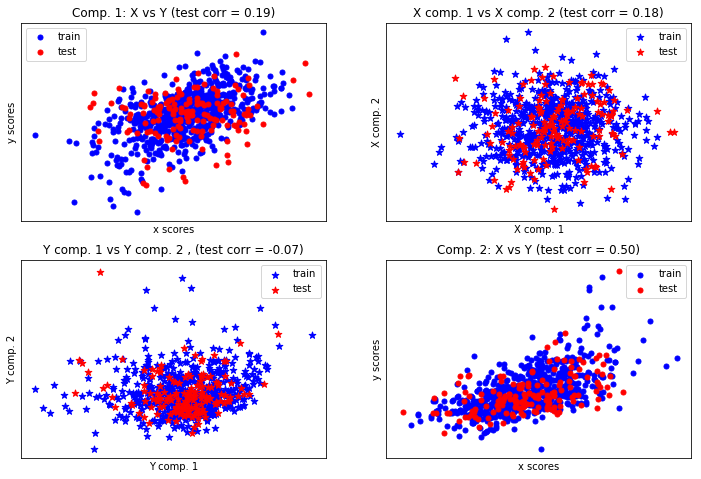

In [121]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

plt.subplot(224)
plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")
plt.subplot(222)
plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("X comp. 1")
plt.ylabel("X comp. 2")
plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
          % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())

plt.subplot(223)
plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("Y comp. 1")
plt.ylabel("Y comp. 2")
plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
          % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())
plt.show()
plt.savefig('corr(T,U)')

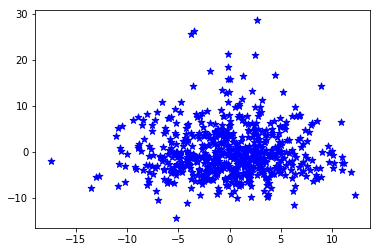

In [102]:
plt.scatter(X_train_r[:, 0], Y_train_r[:, 1], label="train",
            marker="*", c="b", s=50)

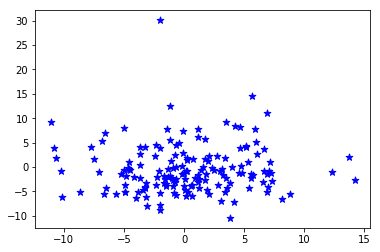

In [103]:
plt.scatter(X_test_r[:, 0], Y_test_r[:, 1], label="train",
            marker="*", c="b", s=50)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 42)

In [ ]:
x_load = []
y_load = []
for n in [2, 3, 5, 10]:
    print(n)
    plsr = PLSRegression(n_components=n, max_iter=1000)
    plsr.fit(X_train, y_train)

    print(plsr.score(X_train, y_train))

    print(plsr.score(X_test, y_test))
    x_load += [plsr.x_loadings_]
    y_load += [plsr.y_loadings_]

@bgutman как к знатоку PLSReg и CCA за небольшим количеством пояснений:
$X = T P^{T} + E$, (n $\times$ p)
$Y = U Q^{T} + F$, (n $\times$ m)

T/U - x/y_scores (n $\times$ l)
P/Q - x/y_loadings (p $\times$ l, m $\times$ l) - ортогональные матрицы,
                                                   которые вообще говоря могут не являтся таковыми.

$\hat{Y} = X B + B_0$

$B <- W(P^{T} W)^{-1} q$
$B_0 <- q_0 - (P^{0})^{T}B$

Идейно мы ищем латентное подпространство, где одновременно живет и X, и Y:

X,Y --> T, U \in R^{n \times l}

(Оно ищется как раз, чтобы максимизировать корреляцию между T, U)

Дальше строится multilinear regression для (T,U):

$U = T W + b + \psi$

$\hat{Y} = (TW + b) Q^{T} + F'$

Мб оно считается не так, там есть какие-то алгоритмы, которые не так топорно как я делают, 
но кажется, что суть не должна сильно меняться. 

(поправь меня если я где ошиблась, пожалуйста) 

Соответственно, матрицами перехода в латентное пространство являются матрицы P, Q.

Пункт 1:
- ты говорил, что хочется посмотреть на стабильность компонент 
    то есть нам хочется увидеть, выделяет ли он одинаковые компоненты P,Q - так?
    (разве в жадном алгоритме оптимизации не будет зашито, что они должны совпадать?)
   
    и там в зависимости от алгоритма могут появляться условия по типу: T T^{T} = I
    что на самом деле дефолтно для sklearn-а
    
    
    (ВСЕ ДАЛЕЕ ПОСЧИТАНО ДЛЯ X = [roi_thick, roi_area, roi_vol], Y = [edges])
    (не нормированные, там в PLSReg scale = True)
    
    (посчитала для разного количества компонент, на одной разбивке - они получились одинаковые)
    см.картинка "different components"
    
    (посчитала для разных разбивок и одиного числа компонент - они получились чуть толще,но идеальные линии)
    см. картинка "different splits"
    
    Если взглянуть на эти вектора глазами, то они все порядка n $\times$ 0.1, n $\in \{1, 2,\ldots, 9\}$
    по первой компоненте mean $\pm$ std : 0.074 $\pm$ 0.045
    по второй компоненте mean $\pm$ std : 0.025 $\pm$ 0.068
    
Пункт 2:
- обычно еще смотрят на скоррелированность по компонентную в латентном пространстве:
    то бишь, на корреляцию векторов матриц T, U (которые мы собственно говоря максимизировали)
    см. картинку "corr(T,U)" для 2 компонент
    
    (посчитала для разных разбиений и двух компонент)
    см. картинкy "1 and 2 split corr(T,U)"
    
    (посчитала для разного числа компонент (4, 5) и (4, 10))
    см. картинку "different comp corr(T,U)" и "different comp corr(T,U) 2"
    
    
    
Пункт 3:    
- r2_score, который получается на тесте ~ 0.03 $\pm$ 0.01 
    кажется, что его можно дотянуть до 0.05 ~
    
    
ТАК ВОТ ВОПРОС:
    1. На что конкретно хотелось посмотреть?
    2. Правда, что имеет смысл посмотреть на X = [all_meshes], Y = [edges] ?    



In [152]:
X = np.concatenate([roi_think, roi_area, roi_vol], axis= -1)
Y = connec[:,0,:,:]
Y = np.array([squareform(one) for one in Y])
print(Y.shape)
x_load = []
y_load = []
X_train_r = []
X_test_r = []
Y_train_r = []
Y_test_r = []


for n in [4, 4748, 10232, 33]:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = n)
    plsr = PLSRegression(n_components=2, max_iter=1000)
    plsr.fit(X_train, y_train)

    print(plsr.score(X_train, y_train))

    print(plsr.score(X_test, y_test))
    x_load += [plsr.x_loadings_]
    y_load += [plsr.y_loadings_]

    x_train_r, y_train_r = plsr.transform(X_train, y_train)
    x_test_r, y_test_r = plsr.transform(X_test, y_test)
    
    X_train_r += [x_train_r]
    X_test_r += [x_test_r]
    
    Y_train_r += [y_train_r]
    Y_test_r += [y_test_r]
    

(789, 2278)
0.0578901873467
0.0165913375758
0.0577509620565
0.0182532682722
0.0546725359025
0.0363555703912
0.0555016647121
0.0267998680698


In [ ]:
plt.subplot(243)
plt.scatter(X_train_r[0][:, 0], Y_train_r[0][:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[0][:, 0], Y_test_r[0][:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('2 test corr = %.2f' %
          np.corrcoef(X_test_r[1][:, 0], Y_test_r[1][:, 0])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

plt.subplot(248)
plt.scatter(X_train_r[0][:, 1], Y_train_r[0][:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[0][:, 1], Y_test_r[0][:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('2 test corr = %.2f' %
          np.corrcoef(X_test_r[0][:, 1], Y_test_r[0][:, 1])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")
plt.subplot(244)
plt.scatter(X_train_r[0][:, 0], X_train_r[0][:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(X_test_r[0][:, 0], X_test_r[0][:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("X comp. 1")
plt.ylabel("X comp. 2")
plt.title('2 test corr = %.2f'
          % np.corrcoef(X_test_r[0][:, 0], X_test_r[0][:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())

plt.subplot(247)
plt.scatter(Y_train_r[0][:, 0], Y_train_r[0][:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(Y_test_r[0][:, 0], Y_test_r[0][:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("Y comp. 1")
plt.ylabel("Y comp. 2")
plt.title('2 test corr = %.2f'
          % np.corrcoef(Y_test_r[0][:, 0], Y_test_r[0][:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())
plt.show()
plt.tight_layout()


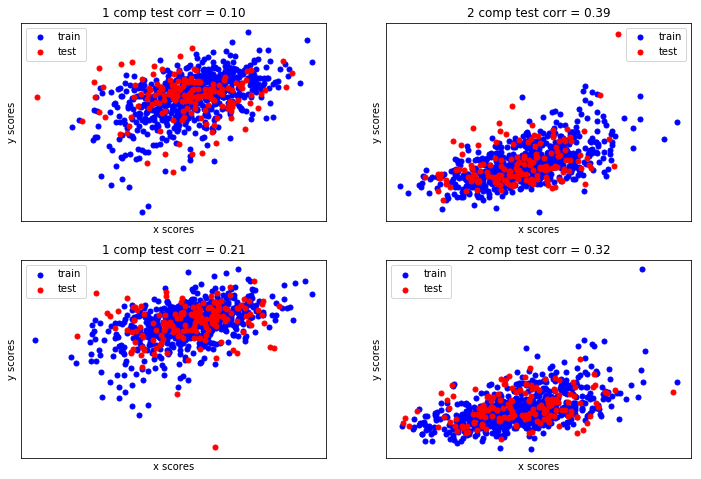

In [156]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_train_r[0][:, 0], Y_train_r[0][:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[0][:, 0], Y_test_r[0][:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('1 comp test corr = %.2f' %
          np.corrcoef(X_test_r[0][:, 0], Y_test_r[0][:, 0])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

plt.subplot(222)
plt.scatter(X_train_r[0][:, 1], Y_train_r[0][:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[0][:, 1], Y_test_r[0][:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('2 comp test corr = %.2f' %
          np.corrcoef(X_test_r[0][:, 1], Y_test_r[0][:, 1])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")
# plt.subplot(243)
# plt.scatter(X_train_r[0][:, 2], Y_train_r[0][:, 2], label="train",
#             marker="*", c="b", s=50)
# plt.scatter(X_test_r[0][:, 2], Y_test_r[0][:, 2], label="test",
#             marker="*", c="r", s=50)
# plt.xlabel("X comp. 1")
# plt.ylabel("X comp. 2")
# plt.title('3 comp test corr = %.2f'
#           % np.corrcoef(X_test_r[0][:, 2], Y_test_r[0][:, 2])[0, 1])
# plt.legend(loc="best")
# plt.xticks(())
# plt.yticks(())

# plt.subplot(244)
# plt.scatter(X_train_r[0][:, 3], Y_train_r[0][:, 3], label="train",
#             marker="*", c="b", s=50)
# plt.scatter(X_test_r[0][:, 3], Y_test_r[0][:, 3], label="test",
#             marker="*", c="r", s=50)
# plt.xlabel("Y comp. 1")
# plt.ylabel("Y comp. 2")
# plt.title('4 comp test corr = %.2f'
#           % np.corrcoef(X_test_r[0][:, 3], Y_test_r[0][:, 3])[0, 1])
# plt.legend(loc="best")
# plt.xticks(())
# plt.yticks(())
##############################
plt.subplot(223)
plt.scatter(X_train_r[2][:, 0], Y_train_r[2][:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[2][:, 0], Y_test_r[2][:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('1 comp test corr = %.2f' %
          np.corrcoef(X_test_r[2][:, 0], Y_test_r[2][:, 0])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

plt.subplot(224)
plt.scatter(X_train_r[2][:, 1], Y_train_r[2][:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[2][:, 1], Y_test_r[2][:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('2 comp test corr = %.2f' %
          np.corrcoef(X_test_r[2][:, 1], Y_test_r[2][:, 1])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")
# plt.subplot(247)
# plt.scatter(X_train_r[2][:, 2], Y_train_r[2][:, 2], label="train",
#             marker="*", c="b", s=50)
# plt.scatter(X_test_r[2][:, 2], Y_test_r[2][:, 2], label="test",
#             marker="*", c="r", s=50)
# plt.xlabel("X comp. 1")
# plt.ylabel("X comp. 2")
# plt.title('3 comp test corr = %.2f'
#           % np.corrcoef(X_test_r[2][:, 2], Y_test_r[2][:, 2])[0, 1])
# plt.legend(loc="best")
# plt.xticks(())
# plt.yticks(())

# plt.subplot(248)
# plt.scatter(X_train_r[2][:, 3], Y_train_r[2][:, 3], label="train",
#             marker="*", c="b", s=50)
# plt.scatter(X_test_r[2][:, 3], Y_test_r[2][:, 3], label="test",
#             marker="*", c="r", s=50)
# plt.xlabel("Y comp. 1")
# plt.ylabel("Y comp. 2")
# plt.title('4 comp test corr = %.2f'
#           % np.corrcoef(X_test_r[2][:, 3], Y_test_r[2][:, 3])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())
plt.show()
plt.tight_layout()
plt.savefig('different_split_corr_T_U_2')

In [145]:
np.corrcoef(X_test_r[2], Y_test_r[2])

array([[ 1.        ,  0.68707686, -0.50766321, ...,  0.13673676,
        -0.79474662,  0.06835123],
       [ 0.68707686,  1.        , -0.47875962, ..., -0.0574556 ,
        -0.60705595,  0.26967704],
       [-0.50766321, -0.47875962,  1.        , ..., -0.05017705,
         0.42793157, -0.28100497],
       ..., 
       [ 0.13673676, -0.0574556 , -0.05017705, ...,  1.        ,
         0.05140833,  0.74851731],
       [-0.79474662, -0.60705595,  0.42793157, ...,  0.05140833,
         1.        , -0.04922956],
       [ 0.06835123,  0.26967704, -0.28100497, ...,  0.74851731,
        -0.04922956,  1.        ]])

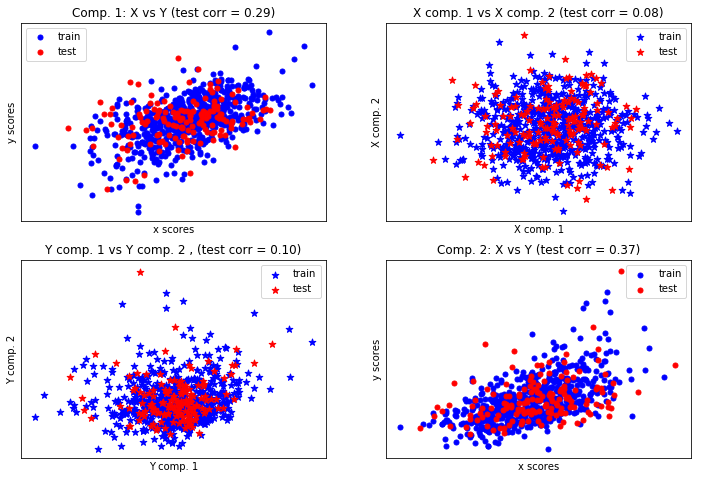

In [132]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_train_r[2][:, 0], Y_train_r[2][:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[2][:, 0], Y_test_r[2][:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[2][:, 0], Y_test_r[2][:, 0])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")

plt.subplot(224)
plt.scatter(X_train_r[2][:, 1], Y_train_r[2][:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[2][:, 1], Y_test_r[2][:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[2][:, 1], Y_test_r[2][:, 1])[0, 1])
plt.xticks(())
plt.yticks(())
plt.legend(loc="best")
plt.subplot(222)
plt.scatter(X_train_r[2][:, 0], X_train_r[2][:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(X_test_r[2][:, 0], X_test_r[2][:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("X comp. 1")
plt.ylabel("X comp. 2")
plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
          % np.corrcoef(X_test_r[2][:, 0], X_test_r[2][:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())

plt.subplot(223)
plt.scatter(Y_train_r[2][:, 0], Y_train_r[2][:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(Y_test_r[2][:, 0], Y_test_r[2][:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("Y comp. 1")
plt.ylabel("Y comp. 2")
plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
          % np.corrcoef(Y_test_r[2][:, 0], Y_test_r[2][:, 1])[0, 1])
plt.legend(loc="best")
plt.xticks(())
plt.yticks(())
plt.show()
plt.savefig('corr(T,U)_split_3')

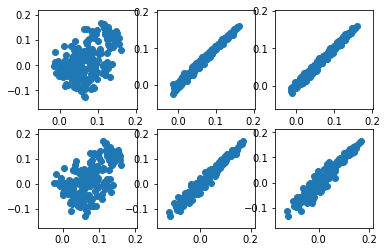

In [154]:
fig, ax = plt.subplots(2,3)
ax[0,0].scatter(x_load[0][:,0], x_load[0][:,1])
ax[0,1].scatter(x_load[0][:,0], x_load[1][:,0])
ax[0,2].scatter(x_load[0][:,0], x_load[2][:,0])

ax[1,0].scatter(x_load[1][:,0], x_load[1][:,1])
ax[1,1].scatter(x_load[0][:,1], x_load[1][:,1])
ax[1,2].scatter(x_load[0][:,1], x_load[2][:,1])



plt.savefig('different_splits')

In [108]:
X_train_r = plsr.transform(X_train)

In [110]:
np.allclose(X_train_r[:,0], plsr.x_scores_[:,0])

True

In [107]:
np.corrcoef(plsr.x_scores_[:,0], plsr.x_scores_[:,1])

array([[  1.00000000e+00,   1.20318240e-16],
       [  1.20318240e-16,   1.00000000e+00]])

In [124]:
x_load[0][:,0].mean(), x_load[0][:,0].std(), x_load[0][:,1].mean(), x_load[0][:,1].std()

(0.073510070190417429,
 0.04510808932624228,
 0.024520506266187649,
 0.06776587885894339)

In [116]:
x_load = []
y_load = []
for n in [2, 3, 5, 10]:
    print(n)
    plsr = PLSRegression(n_components=n, max_iter=1000)
    plsr.fit(X_train, y_train)

    print(plsr.score(X_train, y_train))

    print(plsr.score(X_test, y_test))
    x_load += [plsr.x_loadings_]
    y_load += [plsr.y_loadings_]

2
0.0555016647121
0.0267998680698
3
0.0613854268612
0.0202864848368
5
0.0824921898918
0.0376013065866
10
0.122483422802
0.03875424854


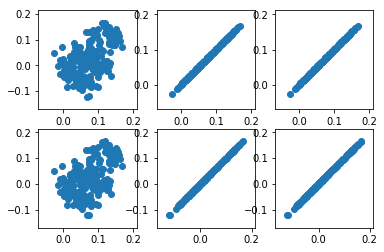

In [118]:
fig, ax = plt.subplots(2,3)
ax[0,0].scatter(x_load[0][:,0], x_load[0][:,1])
ax[0,1].scatter(x_load[0][:,0], x_load[1][:,0])
ax[0,2].scatter(x_load[0][:,0], x_load[2][:,0])

ax[1,0].scatter(x_load[1][:,0], x_load[1][:,1])
ax[1,1].scatter(x_load[0][:,1], x_load[1][:,1])
ax[1,2].scatter(x_load[0][:,1], x_load[2][:,1])
plt.savefig('different components')

In [56]:
#score = 0.03
n2_load_x = plsr.x_loadings_
n2_load_y = plsr.y_loadings_

In [60]:
#score = 0.027
n3_load_x = plsr.x_loadings_
n3_load_y = plsr.y_loadings_

In [64]:
#score = 0.024
n5_load_x = plsr.x_loadings_
n5_load_y = plsr.y_loadings_

In [68]:
#score = 0.033
n10_load_x = plsr.x_loadings_
n10_load_y = plsr.y_loadings_

In [72]:
#score = -0.07
n100_load_x = plsr.x_loadings_
n100_load_y = plsr.y_loadings_

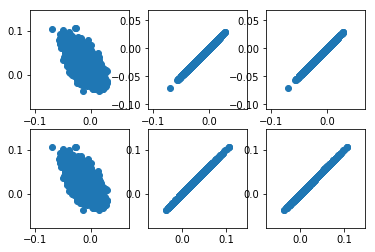

In [79]:
fig, ax = plt.subplots(2,3)
ax[0,0].scatter(n2_load_y[:,0], n2_load_y[:,1])
ax[0,1].scatter(n2_load_y[:,0], n3_load_y[:,0])
ax[0,2].scatter(n2_load_y[:,0], n5_load_y[:,0])

ax[1,0].scatter(n3_load_y[:,0], n3_load_y[:,1])
ax[1,1].scatter(n2_load_y[:,1], n3_load_y[:,1])
ax[1,2].scatter(n2_load_y[:,1], n5_load_y[:,1])

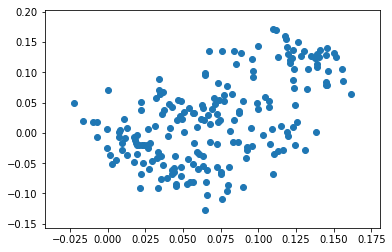

In [75]:
plt.scatter(n2_load_x[:,0], n3_load_x[:,1])

In [11]:
import os

In [12]:
if not os.path.exists(path_res + 'roi_node'):
    os.mkdir(path_res + 'roi_node')

In [3]:
path_res = '../results/'
os.path.exists(path_res)

True

In [4]:
path_data = "/cobrain/groups/ml_group/data/HCP/cleaned_data/"

In [5]:
os.path.exists(path_data)

True

In [22]:
import numpy as np
import pandas as pd
import pickle

import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import r2_score, make_scorer


path_data = "/cobrain/groups/ml_group/data/HCP/cleaned_data/"

with open(path_data + "mean_mesh_labels", 'rb') as f:
    mean_labels = pickle.load(f)


with open(path_data + "subjects_log_jac", 'rb') as f:
    log_jac = pickle.load(f)

with open(path_data + "subjects_thinkness", 'rb') as f:
    thinkness = pickle.load(f)

with open(path_data + "subjects_mesh_area", 'rb') as f:
    mesh_area = pickle.load(f)


targets_name = ['clustering', 'rich_club', 'betweenness', 'closeness',  'degree_centrality', 'eigenvector']

targets_data = []
for name in targets_name:
    with open(path_data + name, 'rb') as f:
        targets_data  += [pickle.load(f)]

print(np.array(targets_data).shape)


cv = ShuffleSplit(test_size=0.2)



elastic_param = {'alpha': [1e-10, 1e-7, 1e-5, 1e-3, 0.1, 1.0, 5, 10, 20, 50, 70, 100,], 
                  'l1_ratio': [1e-10, 1e-7, 1e-3, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'max_iter':[1000,10000]}




path_res = '/home/ayagoz/connec/results/'
                   


thinkness = thinkness.reshape(789,-1)
log_jac = log_jac.reshape(789,-1)
mesh_area = mesh_area.reshape(789,-1)

X = np.concatenate([thinkness, log_jac, mesh_area], axis = -1)






cv = ShuffleSplit(test_size=0.2)

from sklearn.model_selection import cross_val_score

elastic = ElasticNet()


for tr, ts in cv.split(X):
    X_train, X_test = X[tr], X[ts]
    y_train, y_test = targets_data[0][tr], targets_data[0][ts]
    elastic = ElasticNet()
    elastic.fit(X_train, y_train)
    y_pred = elastic.predict(X_test)
    print(r2_score(y_test, y_pred))

(6, 789, 68)


In [ ]:
i = 0
for tr, ts in cv.split(X):
    X_train, X_test = X[tr], X[ts]
    y_train, y_test = targets_data[0][tr], targets_data[0][ts]
    print(i)
    i +=1
    #elastic = ElasticNet()

0


In [7]:
import numpy as np
import pandas as pd
import pickle

import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler


from utils import get_all_attr

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, ShuffleSplit



path_data = "/cobrain/groups/ml_group/data/HCP/cleaned_data/"

with open(path_data + "mean_mesh_labels", 'rb') as f:
    mean_labels = pickle.load(f)

with open(path_data + "normed_connectomes", 'rb') as f:
    Y = pickle.load(f)

with open(path_data + "subjects_log_jac", 'rb') as f:
    log_jac = pickle.load(f)

with open(path_data + "subjects_thinkness", 'rb') as f:
    thinkness = pickle.load(f)

with open(path_data + "subjects_mesh_area", 'rb') as f:
    mesh_area = pickle.load(f)


    
thinkness = thinkness.reshape(789,-1)
log_jac = log_jac.reshape(789,-1)
mesh_area = mesh_area.reshape(789,-1)



cv = ShuffleSplit(test_size=0.2)



elastic_param = {'alpha': [1e-10, 1e-7, 1e-5, 1e-3, 0.1, 1.0, 5, 10, 20, 50, 70, 100,], 
                  'l1_ratio': [1e-10, 1e-7, 1e-3, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'max_iter':[1000,10000]}




path_res = '../results/'

X = get_all_attr(thinkness, log_jac, mesh_area, mean_labels)

del thinkness
del log_jac
del mesh_area
del mean_labels

idx_nodes = list(range(1,4)) + list(range(5,39)) + list(range(40,71))
idx_nodes = np.array(idx_nodes)
print(idx_nodes.shape)
for i in range(68):
    for j in range(i+1,68):
        if np.sum(Y[:,i,j]) != 0:
            node1 = idx_nodes[i]
            node2 = idx_nodes[j]
            print(node1, node2)
            print(i,j)
            

            elastic = ElasticNet()
            StanS = StandardScaler()
            MinM = MinMaxScaler()
            cv = ShuffleSplit(test_size=0.2)
            rg = GridSearchCV(elastic, elastic_param, scoring = 'r2', 
                                    n_jobs=-1, cv = 10)

            rg.fit(X, Y[:,i,j])
            orig = pd.DataFrame.from_dict(rg.cv_results_)
            orig = orig.sort_values(by = 'rank_test_score').iloc[:1]

            rg.fit(StanS.fit_transform(X), Y[:,i,j])
            st = pd.DataFrame.from_dict(rg.cv_results_)
            st = st.sort_values(by = 'rank_test_score').iloc[:1]

            rg.fit(MinM.fit_transform(X), Y[:,i,j])
            mm = pd.DataFrame.from_dict(rg.cv_results_)
            mm = mm.sort_values(by = 'rank_test_score').iloc[:1]

            name_dir = 'exper_elastic_all_meshes_to_edge'
            edge = '/edge[' + str(i) + ',' + str(j) + ']'
            if not os.path.exists(path_res + name_dir):
                os.mkdir(path_res + name_dir)

            if not os.path.exists(path_res + name_dir + edge):
                os.mkdir(path_res + name_dir + edge)
            orig.to_csv(path_res + name_dir + edge +'/results_orig')
            st.to_csv(path_res + name_dir + edge + '/results_st')
            mm.to_csv(path_res + name_dir + edge + '/results_mm')


(68,)
1 2
0 1
1 3
0 2
1 5
0 3
1 7
0 5
1 8
0 6
1 9
0 7
1 10
0 8
1 11
0 9
1 12
0 10
1 13
0 11
1 14
0 12
1 15
0 13
1 16
0 14
1 17
0 15
1 18
0 16
1 19
0 17
1 20
0 18
1 21
0 19
1 22
0 20
1 23
0 21
1 24
0 22
1 25
0 23
1 26
0 24
1 27
0 25
1 28
0 26
1 29
0 27
1 30
0 28
1 31
0 29
1 32
0 30
1 33
0 31
1 34
0 32
1 35
0 33
1 36
0 34
1 37
0 35
1 38
0 36
1 40
0 37
1 42
0 39
1 43
0 40
1 44
0 41
1 45
0 42
1 46
0 43
1 47
0 44
1 48
0 45
1 49
0 46
1 50
0 47
1 51
0 48
1 52
0 49
1 56
0 53
1 57
0 54
1 58
0 55
1 59
0 56
1 60
0 57
1 62
0 59
1 63
0 60
1 64
0 61
1 65
0 62
1 66
0 63
1 70
0 67
2 3
1 2
2 5
1 3
2 6
1 4
2 7
1 5
2 8
1 6
2 9
1 7
2 10
1 8
2 11
1 9
2 12
1 10
2 13
1 11
2 14
1 12
2 15
1 13
2 16
1 14
2 17
1 15
2 18
1 16
2 19
1 17
2 20
1 18
2 21
1 19
2 22
1 20
2 23
1 21
2 24
1 22
2 25
1 23
2 26
1 24
2 27
1 25
2 28
1 26
2 29
1 27
2 30
1 28
2 31
1 29
2 32
1 30
2 33
1 31
2 34
1 32
2 35
1 33
2 36
1 34
2 37
1 35
2 38
1 36
2 40
1 37
2 42
1 39
2 43
1 40
2 44
1 41
2 45
1 42
2 46
1 43
2 47
1 44
2 48
1 45
2 49
1 46
2 

16 40
14 37
16 42
14 39
16 43
14 40
16 44
14 41
16 45
14 42
16 46
14 43
16 47
14 44
16 48
14 45
16 49
14 46
16 50
14 47
16 51
14 48
16 52
14 49
16 56
14 53
16 57
14 54
16 58
14 55
16 59
14 56
16 60
14 57
16 61
14 58
16 62
14 59
16 63
14 60
16 64
14 61
16 65
14 62
16 66
14 63
16 70
14 67
17 18
15 16
17 19
15 17
17 20
15 18
17 21
15 19
17 22
15 20
17 23
15 21
17 24
15 22
17 25
15 23
17 26
15 24
17 27
15 25
17 28
15 26
17 29
15 27
17 30
15 28
17 31
15 29
17 32
15 30
17 34
15 32
17 35
15 33
17 36
15 34
17 37
15 35
17 38
15 36
17 40
15 37
17 42
15 39
17 43
15 40
17 44
15 41
17 45
15 42
17 46
15 43
17 47
15 44
17 48
15 45
17 49
15 46
17 50
15 47
17 51
15 48
17 52
15 49
17 53
15 50
17 54
15 51
17 55
15 52
17 56
15 53
17 57
15 54
17 58
15 55
17 59
15 56
17 60
15 57
17 61
15 58
17 62
15 59
17 63
15 60
17 64
15 61
17 65
15 62
17 66
15 63
17 67
15 64
17 69
15 66
17 70
15 67
18 19
16 17
18 20
16 18
18 21
16 19
18 22
16 20
18 23
16 21
18 24
16 22
18 25
16 23
18 26
16 24
18 27
16 25
18 28
16 26
18 2

36 48
34 45
36 49
34 46
36 50
34 47
36 51
34 48
36 52
34 49
36 53
34 50
36 54
34 51
36 55
34 52
36 56
34 53
36 57
34 54
36 58
34 55
36 59
34 56
36 60
34 57
36 61
34 58
36 62
34 59
36 63
34 60
36 64
34 61
36 65
34 62
36 66
34 63
36 67
34 64
36 68
34 65
36 69
34 66
36 70
34 67
37 38
35 36
37 40
35 37
37 42
35 39
37 43
35 40
37 44
35 41
37 45
35 42
37 46
35 43
37 47
35 44
37 48
35 45
37 49
35 46
37 50
35 47
37 51
35 48
37 52
35 49
37 53
35 50
37 54
35 51
37 55
35 52
37 56
35 53
37 57
35 54
37 58
35 55
37 59
35 56
37 60
35 57
37 61
35 58
37 62
35 59
37 63
35 60
37 64
35 61
37 65
35 62
37 66
35 63
37 67
35 64
37 68
35 65
37 69
35 66
37 70
35 67
38 40
36 37
38 42
36 39
38 43
36 40
38 44
36 41
38 45
36 42
38 46
36 43
38 47
36 44
38 48
36 45
38 49
36 46
38 50
36 47
38 51
36 48
38 52
36 49
38 53
36 50
38 54
36 51
38 55
36 52
38 56
36 53
38 57
36 54
38 58
36 55
38 59
36 56
38 60
36 57
38 61
36 58
38 62
36 59
38 63
36 60
38 64
36 61
38 65
36 62
38 66
36 63
38 67
36 64
38 68
36 65
38 69
36 66
38 7

In [8]:
data = pd.DataFrame(columns = ['smg', 'the'])

In [9]:
data.to_csv(path_res + name_dir + edge +'/results_orig')

In [10]:
path_res + name_dir + edge +'/results_orig'

'../results/exper_elastic_all_meshes_to_edge/edge[66,67]/results_orig'